In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchinfo import summary
from sklearn.model_selection import train_test_split

# **NEURAL NETWORKS AND DEEP LEARNING**

---
### A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---

| **Student**             | **Degree**        | **ID**    | **Contact**                               |
|-------------------------|-------------------|-----------|-------------------------------------------|
| _Giacomo Franceschetto_ | _Physics of Data_ | _2053348_ | _giacomo.franceschetto@studenti.unipd.it_ |

# _Homework 1 - Supervised Deep Learning (classification task)_

## Introduction

In this second part of the homework we have to tackle a classification task. The starting dataset is the famous Fashion-MNIST, where we have many 28x28 images of clothes belonging to 10 different (mutually exclusive) classes.

As we did in the previous task, we are going first to implement a simple (convolutional) model and then to optimize it thanks to an extensive hyperparameter search. This time we will keep fixed the architecture of the network and explore only parameters from the optimizer and training routine.

Lastly, we will try to get some insights on the _under the hoods_ of our model visualizing its weights, activations and receptive fields.

## Dataset

### Downloading

The Fashion-MNIST dataset is easy accessible through the _torchvision_ package.

In [2]:
train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True)

### Visualization

Here we plot few samples of from the dataset

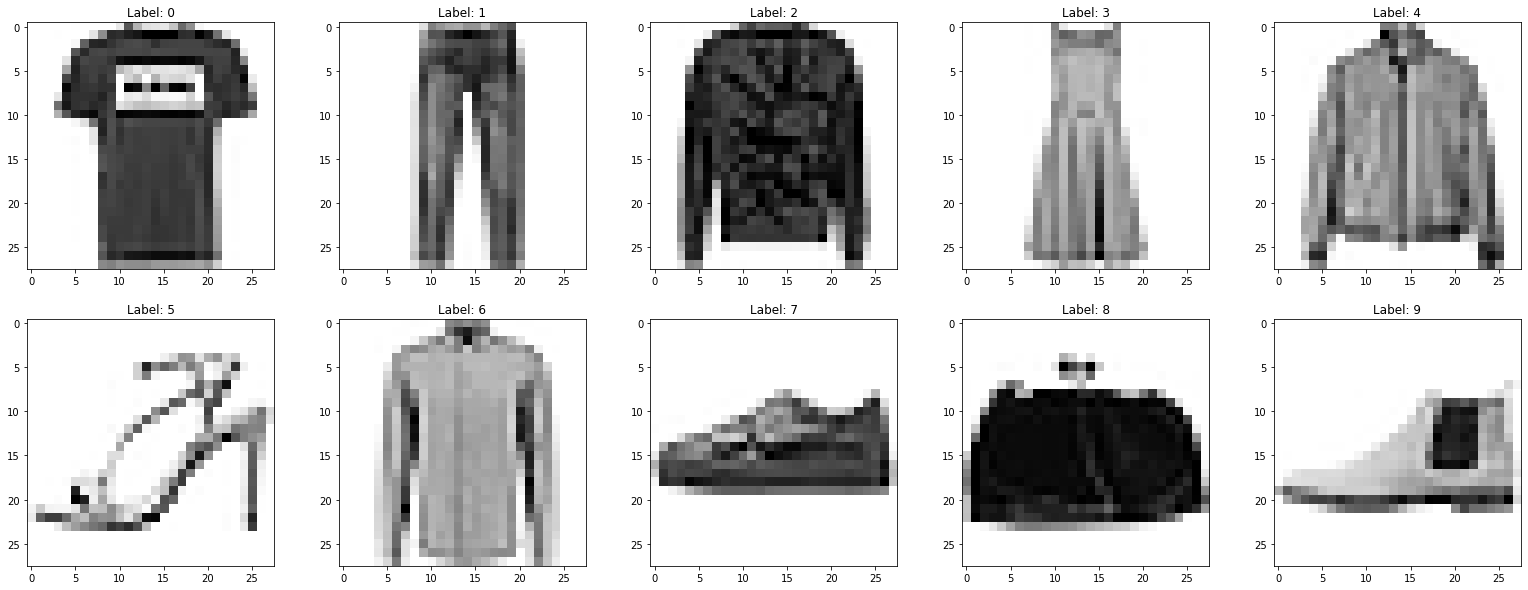

In [3]:
fig, ax = plt.subplots(2, 5, figsize=(27, 10))

i = 0
j = 0
k = 0
for data in train_dataset:
    if data[1] == i:
        ax[j, k].imshow(data[0], cmap='Greys')
        ax[j, k].set_title('Label: {}'.format(i))
        k += 1
        i += 1
        if k == 5:
            k = 0
            j += 1
        if i == 10:
            break

### Data preparation

As our goal is to obtain a network as general as possible and to improve its performance over unseen samples we perform some transformation on our starting dataset.

First of all we normalize the dataset taking its statistical values from the official repository. Thn we perform some random cropping and rotation to increase data variability.

In [4]:
MNIST_MEAN = 0.1307
MNIST_STD  = 0.3081

In [5]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation([-45, 45]),  # This apply a random rotation to the image
    transforms.RandomCrop(28),  # This apply a random crop to the image, ensuring the proper shape
    transforms.ToTensor(), 
    transforms.Normalize((MNIST_MEAN,), (MNIST_STD,))
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((MNIST_MEAN,), (MNIST_STD,))
])

In [6]:
# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

Here we can observe the results of our transformations

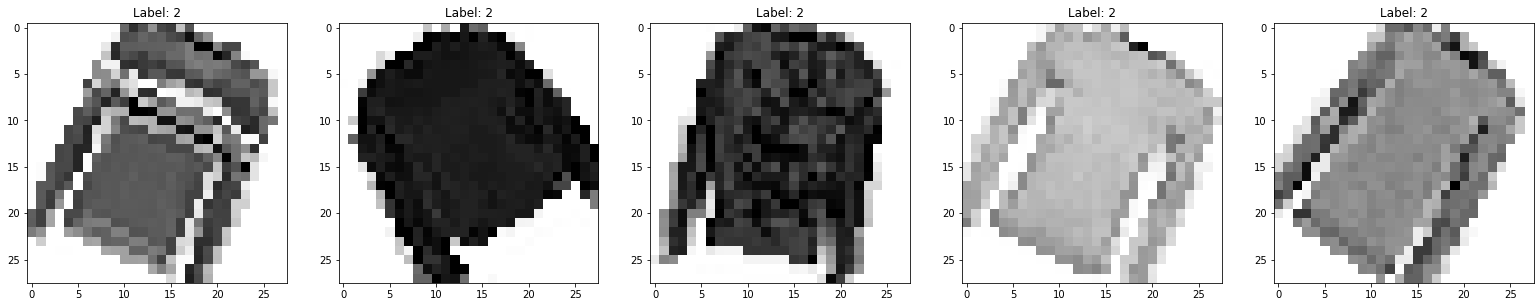

In [7]:
fig, ax = plt.subplots(1, 5, figsize=(27, 8))

label = 2
counter = 0
k = 0
for data in train_dataset:
    if data[1] == label:
        ax[k].imshow(data[0].squeeze().numpy(), cmap='Greys')
        ax[k].set_title('Label: {}'.format(label))
        k += 1
        counter += 1
        if counter == 5:
            break

### Train val split

As this time the dataset size is bigger than the previous task and our local machine is not so powerful, this time we are not going to perform a k-fold cross validation but we will just split the initial training dataset into train and validation. We are taking the 20% of the training samples as validation dataset.

In [8]:
train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.2, random_state=42)

### Data loader

Again, defining dataloaders is very useful and convenient, this time we are selecting a standard _batch_size_ of 256, further analysis on this will be performed afterwards.

In [9]:
### Define train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
### Define validation dataloader
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False)
### Define test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

## A simple network

### Network definition

A first architecture to tackle the task is provided, we opted for a simple convolutional neural networks with the following specs:
- convolutional layer with 16 channels and 3x3 filter, stride 2 and padding 1
- convolutional layer with 32 channels and 3x3 filter, stride 2 and padding 0
- a dropout layer with dropout probability 0.2
- a fully connected network (6*6*32, 128, 64, 10)

In [10]:
class ConvNet(nn.Module):
    
    def __init__(self, No):
        """
        No - Output size
        """
        super().__init__()
        
        ### Convolutional section
        self.conv = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, 
                      stride=2, padding=1),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, 
                      stride=2, padding=0),
            # dropout layer
            nn.Dropout2d(p=0.2),
            nn.ReLU(True),
        )

        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Fully connected section
        self.fc = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=6*6*32, out_features=128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(True),
            # Output layer
            nn.Linear(in_features=64, out_features=No),
        )
        
    def forward(self, x, additional_out=False):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [11]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cpu


In [12]:
# Initialize the network
torch.manual_seed(0)
No = 10
net = ConvNet(No)
net.to(device)

ConvNet(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (3): Dropout2d(p=0.2, inplace=False)
    (4): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Sequential(
    (0): Linear(in_features=1152, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [13]:
print(summary(net, input_size=(1, 1, 28, 28), verbose=0))

Layer (type:depth-idx)                   Output Shape              Param #
ConvNet                                  [1, 10]                   --
├─Sequential: 1-1                        [1, 32, 6, 6]             --
│    └─Conv2d: 2-1                       [1, 16, 14, 14]           160
│    └─ReLU: 2-2                         [1, 16, 14, 14]           --
│    └─Conv2d: 2-3                       [1, 32, 6, 6]             4,640
│    └─Dropout2d: 2-4                    [1, 32, 6, 6]             --
│    └─ReLU: 2-5                         [1, 32, 6, 6]             --
├─Flatten: 1-2                           [1, 1152]                 --
├─Sequential: 1-3                        [1, 10]                   --
│    └─Linear: 2-6                       [1, 128]                  147,584
│    └─ReLU: 2-7                         [1, 128]                  --
│    └─Linear: 2-8                       [1, 64]                   8,256
│    └─ReLU: 2-9                         [1, 64]                   --
│  

### Training loop

As we are dealing with a classification task we have to choose a proper loss, in this case we use the _cross entropy_ loss. Cross entropy loss is a metric took from Information Theory and it is often used in multiclassification tasks because it allow us to compare each class output probability with the actual class expected output 0 or 1.

The optimization instead, is performed using Adam optimizer as in the previous task.


In [14]:
# Define the loss function
loss_fn = nn.CrossEntropyLoss()
# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=1e-3)

This time, during the training loop, we are not only interested in computing the losses. Indeed, we can keep track also of the accuracy of our model, computed as the number of correct predictions / total number of samples.

In [15]:
### TRAINING LOOP
num_epochs = 10
train_loss_log = []
val_loss_log = []
val_acc_log = []
for epoch_num in range(num_epochs):
    print('#################')
    print(f'# EPOCH {epoch_num}')
    print('#################')

    ### TRAIN
    train_loss= []
    net.train() # Training mode (e.g. enable dropout, batchnorm updates,...)
    for sample_batched in train_dataloader:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)

        # Forward pass
        out = net(x_batch)

        # Compute loss
        loss = loss_fn(out, label_batch)

        # Backpropagation
        net.zero_grad()
        loss.backward()

        # Update the weights
        optimizer.step()

        # Save train loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch)

    # Save average train loss
    train_loss = np.mean(train_loss)
    print(f"AVERAGE TRAIN LOSS: {train_loss}")
    train_loss_log.append(train_loss)

    ### VALIDATION
    val_loss = []
    correct = 0
    total = 0
    net.eval() # Evaluation mode (e.g. disable dropout, batchnorm,...)
    with torch.no_grad(): # Disable gradient tracking
        for sample_batched in val_dataloader:
            # Move data to device
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)

            # Forward pass
            out = net(x_batch)

            # Compute predictions
            pred = torch.argmax(out, dim=1).to(device)
            correct += (pred == label_batch).sum()
            total += len(label_batch)

            # Compute loss
            loss = loss_fn(out, label_batch)

            # Save val loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            val_loss.append(loss_batch)

        # Save average validation loss
        val_loss = np.mean(val_loss)
        val_acc = correct / total
        print(f"AVERAGE VAL LOSS: {np.mean(val_loss)}")
        print(f"VAL ACCURACY: {val_acc}")
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)


#################
# EPOCH 0
#################
AVERAGE TRAIN LOSS: 0.998052716255188
AVERAGE VAL LOSS: 0.6827267408370972
VAL ACCURACY: 0.7490000128746033
#################
# EPOCH 1
#################
AVERAGE TRAIN LOSS: 0.6540671586990356
AVERAGE VAL LOSS: 0.6194280385971069
VAL ACCURACY: 0.7607499957084656
#################
# EPOCH 2
#################
AVERAGE TRAIN LOSS: 0.5861637592315674
AVERAGE VAL LOSS: 0.5367886424064636
VAL ACCURACY: 0.8048333525657654
#################
# EPOCH 3
#################
AVERAGE TRAIN LOSS: 0.5370085835456848
AVERAGE VAL LOSS: 0.517419159412384
VAL ACCURACY: 0.8141666650772095
#################
# EPOCH 4
#################
AVERAGE TRAIN LOSS: 0.5039125680923462
AVERAGE VAL LOSS: 0.49282148480415344
VAL ACCURACY: 0.8195833563804626
#################
# EPOCH 5
#################
AVERAGE TRAIN LOSS: 0.47454920411109924
AVERAGE VAL LOSS: 0.4733721613883972
VAL ACCURACY: 0.828083336353302
#################
# EPOCH 6
#################
AVERAGE TRAIN LOSS: 0.455

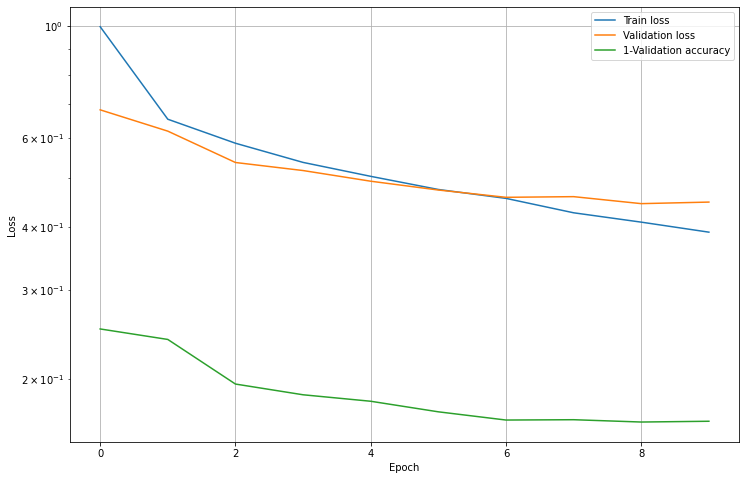

In [16]:
# Plot losses & 1- accuracy
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.semilogy(1-np.array(val_acc_log), label='1-Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

### Network evalutaion

In [17]:
### TEST
test_loss= []
correct = 0
total = 0
predictions = torch.empty(0, dtype=torch.long).to(device)
net.eval() # Evaluation mode (e.g. disable dropout, batchnorm,...)
with torch.no_grad(): # Disable gradient tracking
    for sample_batched in test_dataloader:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)

        # Forward pass
        out = net(x_batch)

        # Compute predictions
        pred = torch.argmax(out, dim=1).to(device)
        predictions = torch.cat([predictions, pred])
        correct += (pred == label_batch).sum()
        total += len(label_batch)

        # Compute loss
        loss = loss_fn(out, label_batch)

        # Save val loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        test_loss.append(loss_batch)

    # Save average validation loss
    test_loss = np.mean(test_loss)
    test_acc = correct / total
    print(f"AVERAGE TEST LOSS: {np.mean(test_loss)}")
    print(f"TEST ACCURACY: {test_acc}")

AVERAGE TEST LOSS: 0.45487767457962036
TEST ACCURACY: 0.8334000110626221


After testing our network over the test dataset we can state that, despite using a simple model for a few epochs, we obtain a pretty good result. Another useful manner to visualize our network performance is through the confusion matrix. Basically, we consider a 2d matrix where one axis represents the true lables and the other the predicted ones. Indeed, the counts on the diagonal show the correct predicitons instead the others are the errors.

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay

In [19]:
predictions_array = predictions.cpu().numpy()
labels_array = test_dataset.targets.cpu().numpy()

In [20]:
labels_dict = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }

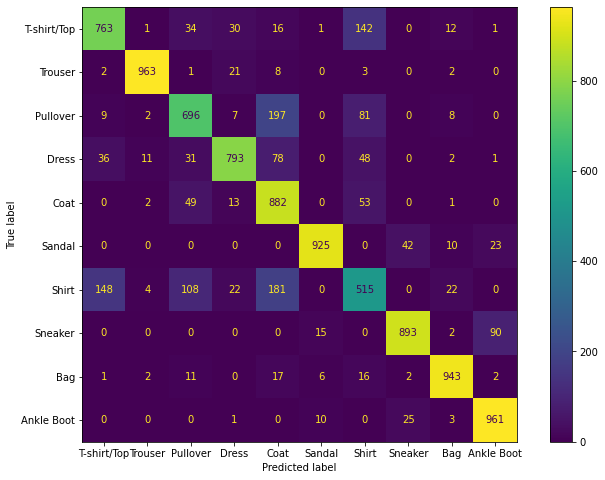

In [21]:
fig, ax = plt.subplots(figsize=(12, 8))
ConfusionMatrixDisplay.from_predictions(labels_array, predictions_array, 
                                        display_labels=labels_dict.values(),
                                        ax=ax)
plt.show()

Other than confirming an overall good perfomance we can also highlight some of the more frequent errors are somehow _expected_ as the two starting images are very similar. (shirt, t-shirt/ pullover, coat)

## Hyperparameters tuning

The optimization routine is performed as in the previous task. This time we are keeping fixed the architecture and we are exploring the following parameters:

- dropout layer probability [0., 0.4]
- activation function (ReLU, LeakyReLU) (leaky relu add a small slope for x<0 inputs)
- l2 regularization lambda parameter [1e-3, 1e-1] _logscale_ (also l1 was tested initially but then l2 preferred)
- batch size (64, 128, 256)
- optimizer (Adam, RMSprop, SGD)
- learning rate [1e-5, 1e-1] _logscale_

An Optuna study is performed with the TPE sampler for 100 trials.

In [22]:
import optuna
from sklearn.model_selection import KFold
from torchinfo import summary

In [23]:
class OptunaConvNet(nn.Module):
    
    def __init__(self, params, No, opt=True):
        """
        No - Output size
        """
        super().__init__()
        
        ### Convolutional section

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, 
                               stride=2, padding=1)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3,
                               stride=2, padding=1)
        # Dropout
        p = params.suggest_float(f'dropout', 0, 0.4) if opt else params[f'dropout']
        self.dropout = nn.Dropout(p)

        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Fully connected section

        # First linear layer
        self.fc1 = nn.Linear(in_features=7*7*32, out_features=128)
        # Second linear layer
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        # Output layer
        self.out = nn.Linear(in_features=64, out_features=No)

        ### Activation functions
        self.act = getattr(nn, params.suggest_categorical("activation", ["ReLU", "LeakyReLU"]))() if opt else getattr(nn, params['activation'])()
        
    def forward(self, x, additional_out=False):
        x = self.act(self.conv1(x))
        x = self.act(self.conv2(x))
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.out(x)
        return x

In [24]:
def train_and_evaluate(train_dataloader, val_dataloader, params, net, log=False):
    
    # Check if the GPU is available
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    # Define the loss function
    loss_fn = params['loss']
    # Define the optimizer
    optimizer = getattr(optim, params['optimizer'])(net.parameters(), lr= params['learning_rate'])

    ### TRAINING LOOP
    num_epochs = params['num_epochs']
    train_loss_log = []
    val_loss_log = []
    val_acc_log = []
    for epoch_num in range(num_epochs):

        ### TRAIN
        train_loss= []
        net.train() # Training mode (e.g. enable dropout, batchnorm updates,...)
        for sample_batched in train_dataloader:
            # Move data to device
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)

            # Forward pass
            out = net(x_batch)

            # Compute loss
            loss = loss_fn(out, label_batch)

            # l2 regularization
            if params['l2_lambda']!= 0 :
                loss += sum(p.pow(2.0).sum() for p in net.parameters()) * params['l2_lambda']

            # (or) l1 regularization
            if params['l1_lambda']!= 0 :
                loss += sum(p.abs().sum() for p in net.parameters()) * params['l1_lambda']

            # Backpropagation
            net.zero_grad()
            loss.backward()

            # Update the weights
            optimizer.step()

            # Save train loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            train_loss.append(loss_batch)

        # Save average train loss
        train_loss = np.mean(train_loss)
        train_loss_log.append(train_loss)

        ### VALIDATION
        val_loss = []
        correct = 0
        total = 0
        net.eval() # Evaluation mode (e.g. disable dropout, batchnorm,...)
        with torch.no_grad(): # Disable gradient tracking
            for sample_batched in val_dataloader:
                # Move data to device
                x_batch = sample_batched[0].to(device)
                label_batch = sample_batched[1].to(device)

                # Forward pass
                out = net(x_batch)

                # Compute predictions
                pred = torch.argmax(out, dim=1).to(device)
                correct += (pred == label_batch).sum()
                total += len(label_batch)

                # Compute loss
                loss = loss_fn(out, label_batch)

                ## l2 regularization
                if params['l2_lambda']!= 0 :
                    loss += sum(p.pow(2.0).sum() for p in net.parameters()) * params['l2_lambda']

                # (or) l1 regularization
                if params['l1_lambda']!= 0 :
                    loss += sum(p.abs().sum() for p in net.parameters()) * params['l1_lambda']

                # Save val loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                val_loss.append(loss_batch)

            # Save average validation loss
            val_loss = np.mean(val_loss)
            val_acc = correct / total
            val_loss_log.append(val_loss)
            val_acc_log.append(val_acc)

    if log:
        return train_loss_log, val_loss_log, val_acc_log

    return val_acc

In [25]:
train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True)
train_dataset.transform = train_transform

In [26]:
def objective(trial, train_dataset_):

    params = {
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
              'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"]),
              'loss': nn.CrossEntropyLoss(),
              'num_epochs': 10,
              'l2_lambda': trial.suggest_loguniform('l2_lambda', 1e-3, 1e-1),
              'l1_lambda': 0,
              'dropout': trial.suggest_float('dropout', 0, 0.4),
              'batch_size': trial.suggest_categorical('batch_size', [64, 128, 256]),
              }
    
    net = OptunaConvNet(trial, No=10)

    train_dataset, val_dataset = train_test_split(train_dataset_, test_size=0.2, random_state=42)

    train_dataloader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True, num_workers=0)
    val_dataloader   = DataLoader(val_dataset,  batch_size=len(val_dataset), shuffle=True, num_workers=0)
    
    acc = train_and_evaluate(train_dataloader, val_dataloader, params, net)

    return acc

In [27]:
def objective_cv(trial, train_dataset_):

    params = {
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
              'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"]),
              'loss': nn.CrossEntropyLoss(),
              'num_epochs': 10,
              'l2_lambda': trial.suggest_loguniform('l2_lambda', 1e-3, 1e-1),
              'l1_lambda': 0,
              'dropout': trial.suggest_float('dropout', 0, 0.4),
              'batch_size': trial.suggest_categorical('batch_size', [64, 128, 256]),
              }
    
    net = OptunaConvNet(trial, No=10)

    #k-fold cross validation
    fold = KFold(n_splits=4, shuffle=True, random_state=0)
    accuracies = []
    for fold_idx, (train_idx, valid_idx) in enumerate(fold.split(range(len(train_dataset_)))):
        train_dataset = torch.utils.data.Subset(train_dataset_, train_idx)
        valid_dataset = torch.utils.data.Subset(train_dataset_, valid_idx)

        train_dataloader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True, num_workers=0)
        val_dataloader   = DataLoader(val_dataset,  batch_size=len(val_dataset), shuffle=True, num_workers=0)
        
        acc = train_and_evaluate(train_dataloader, val_dataloader, params, net)
        accuracies.append(acc)

    return np.mean(accuracies)

In [28]:
dummy_objective = lambda trial: objective(trial, train_dataset)
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(dummy_objective, n_trials=100)

[I 2022-09-05 22:55:57,548] A new study created in memory with name: no-name-8b68639d-cb20-46b5-8c64-7f2de9fa76fe
[I 2022-09-05 22:57:13,405] Trial 0 finished with value: 0.7236666679382324 and parameters: {'learning_rate': 2.394565825330921e-05, 'optimizer': 'RMSprop', 'l2_lambda': 0.005917277587663627, 'dropout': 0.32125377364842084, 'batch_size': 128, 'activation': 'LeakyReLU'}. Best is trial 0 with value: 0.7236666679382324.
[I 2022-09-05 22:57:56,986] Trial 1 finished with value: 0.7459999918937683 and parameters: {'learning_rate': 3.919918074460655e-05, 'optimizer': 'Adam', 'l2_lambda': 0.0012017858021089922, 'dropout': 0.15199946448461918, 'batch_size': 256, 'activation': 'ReLU'}. Best is trial 1 with value: 0.7459999918937683.
[I 2022-09-05 22:59:26,812] Trial 2 finished with value: 0.7891666889190674 and parameters: {'learning_rate': 0.0081578564612172, 'optimizer': 'Adam', 'l2_lambda': 0.0010774159266480794, 'dropout': 0.3883748809368185, 'batch_size': 64, 'activation': 'ReLU

In [29]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.8385833501815796
  Params: 
    learning_rate: 0.0006084862850531236
    optimizer: Adam
    l2_lambda: 0.0011346320390442537
    dropout: 0.2650446708744719
    batch_size: 64
    activation: LeakyReLU


## Training the best model

In [30]:
best_params = trial.params
best_params['num_epochs'] = 50
best_params['loss'] = nn.CrossEntropyLoss()
best_params['l1_lambda'] = 0

net = OptunaConvNet(best_params, No=10, opt=False)
print(summary(net, (1, 1, 28, 28)))

train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.2, random_state=42)

train_dataloader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True, num_workers=0)
val_dataloader   = DataLoader(val_dataset,  batch_size=len(val_dataset), shuffle=True, num_workers=0)

train_loss_log, val_loss_log, val_acc_log = train_and_evaluate(train_dataloader, val_dataloader, best_params, net, log=True)

Layer (type:depth-idx)                   Output Shape              Param #
OptunaConvNet                            [1, 10]                   --
├─Conv2d: 1-1                            [1, 16, 14, 14]           160
├─LeakyReLU: 1-2                         [1, 16, 14, 14]           --
├─Conv2d: 1-3                            [1, 32, 7, 7]             4,640
├─LeakyReLU: 1-4                         [1, 32, 7, 7]             --
├─Dropout: 1-5                           [1, 32, 7, 7]             --
├─Flatten: 1-6                           [1, 1568]                 --
├─Linear: 1-7                            [1, 128]                  200,832
├─LeakyReLU: 1-8                         [1, 128]                  --
├─Linear: 1-9                            [1, 64]                   8,256
├─LeakyReLU: 1-10                        [1, 64]                   --
├─Linear: 1-11                           [1, 10]                   650
Total params: 214,538
Trainable params: 214,538
Non-trainable params: 0


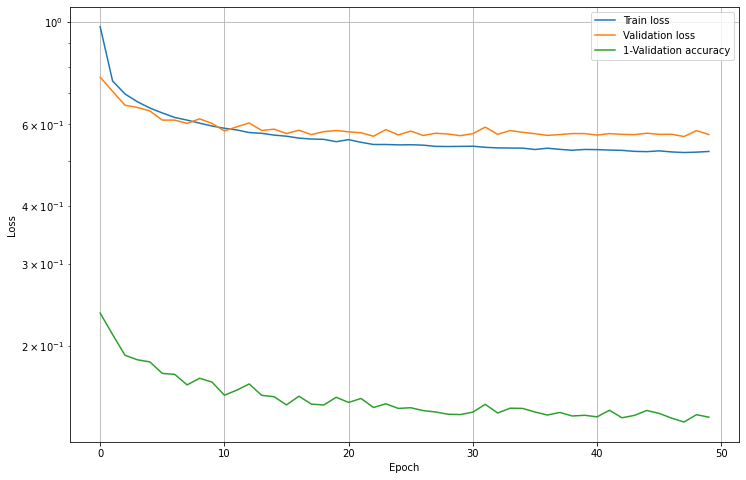

In [31]:
# Plot losses & 1- accuracy
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.semilogy(1-np.array(val_acc_log), label='1-Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

### Network evaluation

In [32]:
### TEST
test_loss= []
correct = 0
total = 0
predictions = torch.empty(0, dtype=torch.long).to(device)
net.eval() # Evaluation mode (e.g. disable dropout, batchnorm,...)
with torch.no_grad(): # Disable gradient tracking
    for sample_batched in test_dataloader:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)

        # Forward pass
        out = net(x_batch)

        # Compute predictions
        pred = torch.argmax(out, dim=1).to(device)
        predictions = torch.cat([predictions, pred])
        correct += (pred == label_batch).sum()
        total += len(label_batch)

        # Compute loss
        loss = loss_fn(out, label_batch)

        ## l2 regularization
        if best_params['l2_lambda']!= 0 :
            loss += sum(p.pow(2.0).sum() for p in net.parameters()) * best_params['l2_lambda']

        # (or) l1 regularization
        if best_params['l1_lambda']!= 0 :
            loss += sum(p.abs().sum() for p in net.parameters()) * best_params['l1_lambda']

        # Save val loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        test_loss.append(loss_batch)

    # Save average validation loss
    test_loss = np.mean(test_loss)
    test_acc = correct / total
    print(f"AVERAGE TEST LOSS: {np.mean(test_loss)}")
    print(f"TEST ACCURACY: {test_acc}")

AVERAGE TEST LOSS: 0.6039179563522339
TEST ACCURACY: 0.8511999845504761


It is worth mentioning that we are computing the loss with the regularization term (useless in test phase) and that's why it does not decrease with respect to the previous model. Anyway, we are more interested in the accuracy for a classification task and we observe how the accuracy is slighlty increased with respect to the previous model. This is confirmed also by the confusion matrix.

In [33]:
predictions_array = predictions.cpu().numpy()
labels_array = test_dataset.targets.cpu().numpy()

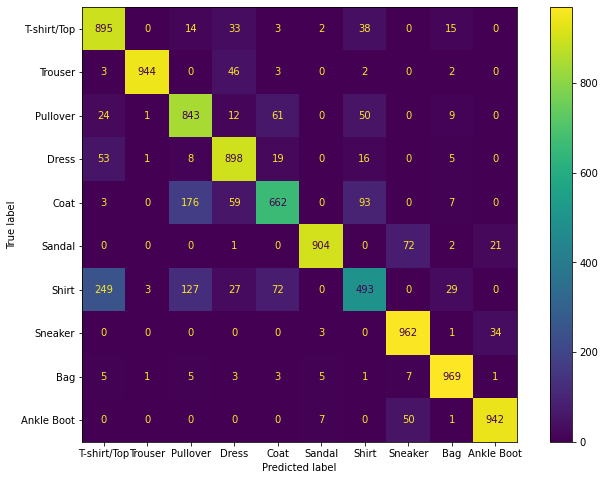

In [34]:
fig, ax = plt.subplots(figsize=(12, 8))
ConfusionMatrixDisplay.from_predictions(labels_array, predictions_array, 
                                        display_labels=labels_dict.values(),
                                        ax=ax)
plt.show()


The improvement is not huge despite the fact that the hyperparameter optimization was computationally demanding. A takeaway message from this analysis should be that manual optimization can help a lot on obtaining good performances depending on the user experience and then hyperparameter optimization can help to increase the accuracy but is better to use it over a small parameter space than to bruteforce a huge set of parameters without previous knowledge on them.

### Saving network

In [35]:
### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
net_state_dict = net.state_dict()
print(net_state_dict.keys())
# Save the state dict to a file
torch.save(net_state_dict, 'covn_net_parameters.torch')

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'out.weight', 'out.bias'])


In [2]:
best_params = {'learning_rate': 0.0006084862850531236,
 'optimizer': 'Adam',
 'l2_lambda': 0.0011346320390442537,
 'dropout': 0.2650446708744719,
 'batch_size': 64,
 'activation': 'LeakyReLU',
 'num_epochs': 50,
 'loss': CrossEntropyLoss(),
 'l1_lambda': 0}

### Loading network

In [5]:
net = OptunaConvNet(best_params, No=10, opt=False)

net_state_dict = torch.load('covn_net_parameters.torch')

net.load_state_dict(net_state_dict)

<All keys matched successfully>

### Weights histogram

In [37]:
conv1_weights = net.conv1.weight.data.cpu().numpy()
conv2_weights = net.conv2.weight.data.cpu().numpy()
fc1_weights = net.fc1.weight.data.cpu().numpy()
fc2_weights = net.fc2.weight.data.cpu().numpy()
out_weights = net.out.weight.data.cpu().numpy()

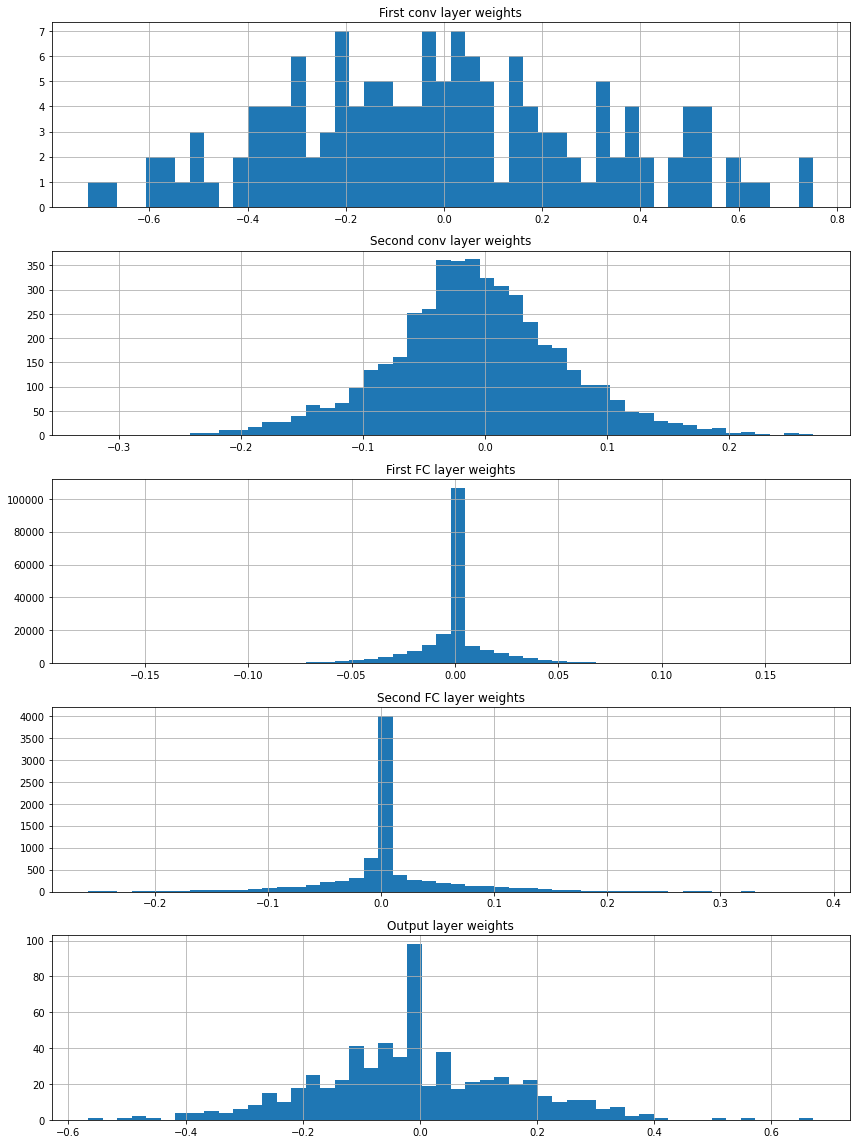

In [38]:
# Weights histogram
fig, axs = plt.subplots(5, 1, figsize=(12,16))
axs[0].hist(conv1_weights.flatten(), 50)
axs[0].set_title('First conv layer weights')
axs[1].hist(conv2_weights.flatten(), 50)
axs[1].set_title('Second conv layer weights')
axs[2].hist(fc1_weights.flatten(), 50)
axs[2].set_title('First FC layer weights')
axs[3].hist(fc2_weights.flatten(), 50)
axs[3].set_title('Second FC layer weights')
axs[4].hist(out_weights.flatten(), 50)
axs[4].set_title('Output layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

As in the previous task we see the effect of the regularization in the small magnitude of the weights centred in 0.

### Receptive fields

A 2d visualization of the convolutional weights helps a lot to explain what the network is learnig. In the following plots we observe the weights of the filters of the two convolutional layers. If the second layers' filters are more abstract and difficult to explain, some of the filters of the first convolutional layers clearly learnt to detect edges and lines.

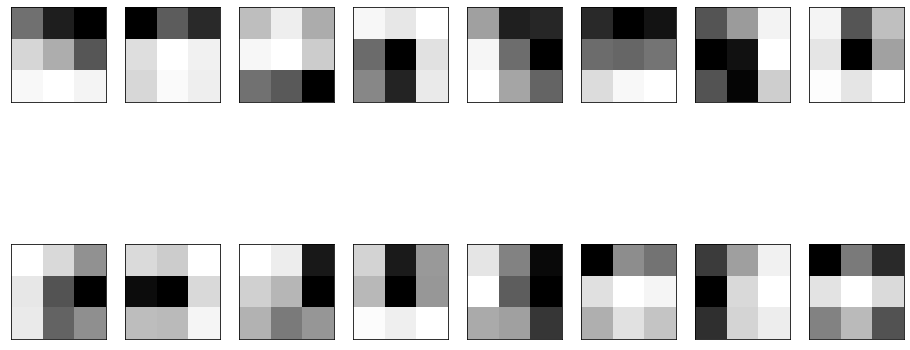

In [39]:
fig, ax = plt.subplots(2,8, figsize=(16, 8))

i = 0
for j in range(2):
    for k in range(8):
        ax[j, k].imshow( conv1_weights[i, 0, :, :], cmap='Greys')
        ax[j, k].set_xticks([])
        ax[j, k].set_yticks([])
        i += 1

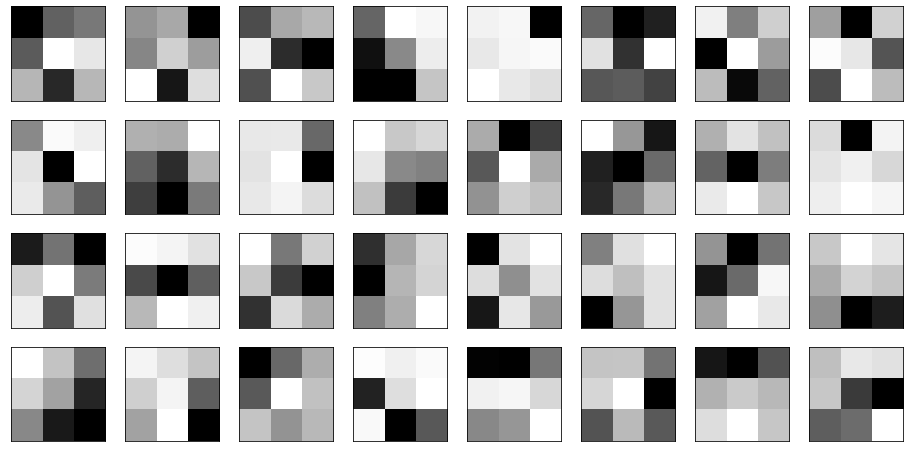

In [40]:
fig, ax = plt.subplots(4,8, figsize=(16, 8))

i = 0
for j in range(4):
    for k in range(8):
        ax[j, k].imshow( conv2_weights[i, 0, :, :], cmap='Greys')
        ax[j, k].set_xticks([])
        ax[j, k].set_yticks([])
        i += 1

### Activations

Another interesting visualization tool consist in recovering a sample and look how the network process it at each step of the convolutional layers

In [48]:
# add hook to each layer to record all the activations
activations = []

def get_activation(layer, input, output):
    activations.append(output.detach())

# register hooks
hook_conv1 = net.conv1.register_forward_hook(get_activation)
hook_conv2 = net.conv2.register_forward_hook(get_activation)

In [59]:
x = train_dataset[5][0]

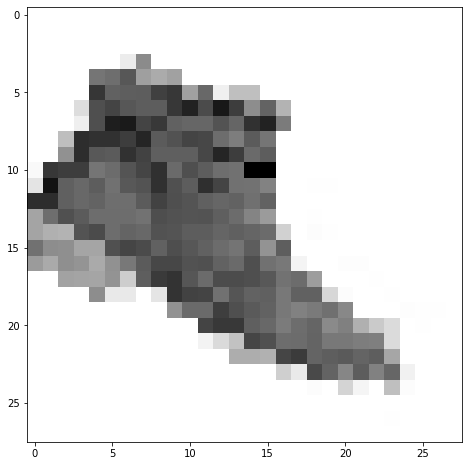

In [60]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.imshow(x.squeeze().numpy(), cmap='Greys')
plt.show()

In [61]:
y = net(x.unsqueeze(0))

In [62]:
hook_conv1.remove()
hook_conv2.remove()

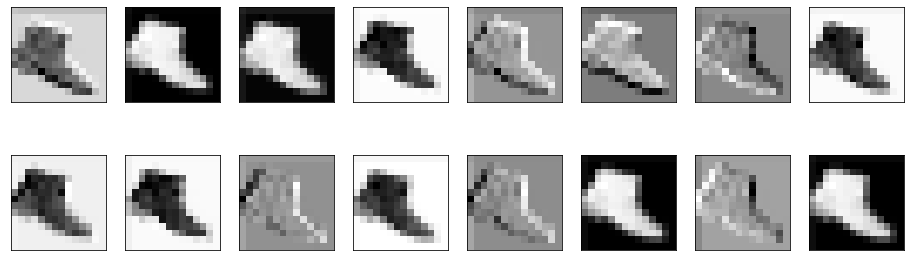

In [63]:
fig, ax = plt.subplots(2,8, figsize=(16, 5))

i = 0
for j in range(2):
    for k in range(8):
        ax[j, k].imshow( activations[0][0, i, :, :], cmap='Greys')
        ax[j, k].set_xticks([])
        ax[j, k].set_yticks([])
        i += 1

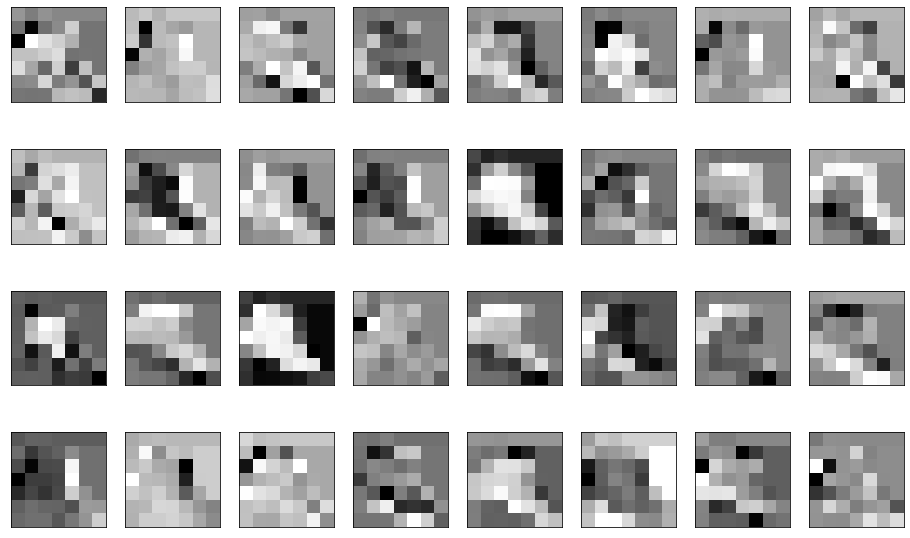

In [64]:
fig, ax = plt.subplots(4,8, figsize=(16, 10))

i = 0
for j in range(4):
    for k in range(8):
        ax[j, k].imshow( activations[1][0, i, :, :], cmap='Greys')
        ax[j, k].set_xticks([])
        ax[j, k].set_yticks([])
        i += 1

As guessed in the previous subsection we observe that the first convolutional layer output highlights the edges of the input sample while the second convolutional layer is more abstract and difficult to explain.